In [2]:
import gensim
from nltk.cluster.kmeans import KMeansClusterer
import pandas as pd
from nltk.corpus import stopwords
import logging
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import cluster
from gensim.parsing.preprocessing import remove_stopwords, strip_multiple_whitespaces, strip_punctuation, strip_non_alphanum
import time
%matplotlib inline

logging.basicConfig(
        format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Stopwords to remove from dataset
stop_words = stopwords.words('english')

stop_words1 = ["http", "https", "com", "and", "www", "twitter",
               "instagram", "facebook", "lionheart", "lionheartmuzik",
               "soundcloud", "pharaoh", "youtube", "html", "spotify"]

# Preprocessing dataset
def read_input(input_file):
    
    logging.info("reading file {0}...this may take a while".format(input_file))
        
    for i, line in enumerate(input_file):
 
        if (i % 10000 == 0):
            logging.info("read {0} tweets".format(i))
        # do some pre-processing and return list of words for each tweet text
        line = str(line)
        line = strip_non_alphanum(line)
        line = strip_punctuation(line)
        line = remove_stopwords(line)
        line = line.lower().split()
        line = [w for w in line if w not in stop_words]
        line = [w for w in line if w not in stop_words1]
        line = str(line)
        line = strip_multiple_whitespaces(line)
        yield gensim.utils.simple_preprocess(line, max_len=20)


In [7]:
#Loading Dataset
data = pd.read_csv("bp.csv")

sentences = data["text"]
#sentences = sentences[5000:10000]

# read the tokenized tweets into a list
# each tweet item becomes a serries of words
# so this becomes a list of lists
documents = list(read_input(sentences))
logging.info("Done reading data file")


LabeledSentence1 = gensim.models.doc2vec.TaggedDocument

def Documents(documents):
    used_docs = []
    for i, doc in enumerate(documents):
        used_docs.append(LabeledSentence1(doc,[i]))
    return used_docs

#tagged_documents = Documents(documents)
#count = len(documents)

# build vocabulary and train model

#model = gensim.models.Doc2Vec(tagged_documents, size = 256, window = 10, min_count = 2,
#                    workers=7, dm = 1, alpha=0.025, min_alpha=0.001)

#model.train(tagged_documents, total_examples=count, epochs=10,
#                start_alpha=0.002, end_alpha=-0.016)

#model.save('BlackPanther_Doc2Vec.model')

model = gensim.models.Doc2Vec.load('BlackPanther_Doc2Vec.model')

2018-09-20 16:39:54,205 : INFO : loading Doc2Vec object from BlackPanther_Doc2Vec.model
2018-09-20 16:39:58,346 : INFO : loading vocabulary recursively from BlackPanther_Doc2Vec.model.vocabulary.* with mmap=None
2018-09-20 16:39:58,362 : INFO : loading trainables recursively from BlackPanther_Doc2Vec.model.trainables.* with mmap=None
2018-09-20 16:39:58,377 : INFO : loading syn1neg from BlackPanther_Doc2Vec.model.trainables.syn1neg.npy with mmap=None
2018-09-20 16:40:02,228 : INFO : loading wv recursively from BlackPanther_Doc2Vec.model.wv.* with mmap=None
2018-09-20 16:40:02,228 : INFO : loading vectors from BlackPanther_Doc2Vec.model.wv.vectors.npy with mmap=None
2018-09-20 16:40:06,627 : INFO : loading docvecs recursively from BlackPanther_Doc2Vec.model.docvecs.* with mmap=None
2018-09-20 16:40:06,627 : INFO : loading vectors_docs from BlackPanther_Doc2Vec.model.docvecs.vectors_docs.npy with mmap=None
2018-09-20 16:40:18,569 : INFO : loaded BlackPanther_Doc2Vec.model


In [12]:
samp_sentences = documents[:100000]
vectors = []
for sentence in samp_sentences:
    vectors.append(model.infer_vector(sentence))
    
vec_array = np.asarray(vectors)
start = time.time()
NUM_CLUSTERS = 8

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(vec_array)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

display_sentences = list(sentences[:100000])
cluster_dict = {}
for i in range(0, len(labels)):
    cluster_dict.setdefault(labels[i], [])
    cluster_dict[labels[i]].append(display_sentences[i])

for key, value in sorted(cluster_dict.items()):
    print("Cluster_ID:{0}>>>>>>>>>>>>>\n".format(key))
    for val in value[:10]:
        print("{}\n".format(val))



Cluster_ID:0>>>>>>>>>>>>>

More gorgeousness, and Storm being more dramatic than anyone. #BlackPanther (by Ta-Nehisi Coates, Leonard Kirk, Marc Deering, Walden Wong, Laura Martin, Matt Milla, and Joe Sabino) pic.twitter.com/H89OO8efl6

The lightning in the last panel is gorgeous. #BlackPanther (by Ta-Nehisi Coates, Leonard Kirk, Marc Deering, Walden Wong, Laura Martin, Matt Milla, and Joe Sabino) pic.twitter.com/9HNnHKFCd1

Ça fait maintenant un mois que je cherche désespérément un site de streaming qui diffuse #BlackPanther avec une qualité qui dépasse le flou, si quelqu’un à une solution je suis preneuse

Olha o clima de animação no set de filmagem do Pantera Negra #panteranegra #blackpanther https://www. instagram.com/p/Bh40pGJgj0Q/

#MCU characters: Chadwick Boseman * @chadwickboseman * is T’Challa / #BlackPanther , who is the king of #Wakanda and gains his enhanced strength by ingesting the Heart-Shaped Herb. #InfinityWarEvent #MarvelPartner http://www. thepositivemom.com/avengers

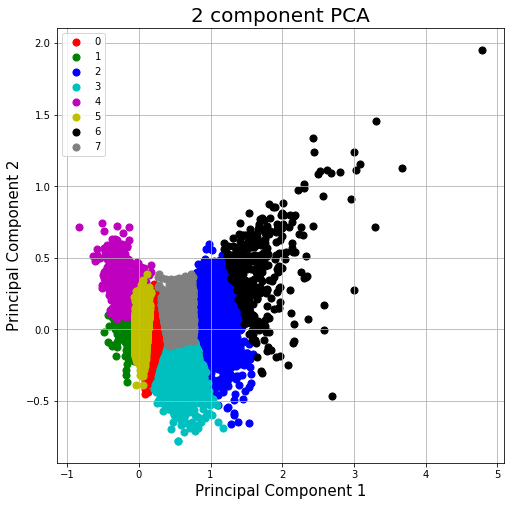

In [14]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(vec_array)

labeled_array = np.column_stack((principalComponents, labels))

finalDf = pd.DataFrame({'principal component 1':labeled_array[:,0],'principal component 2':labeled_array[:,1],
                        'target':labeled_array[:,2]})

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1, 2, 3, 4, 5, 6, 7]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
